# Simulating Liquid Water

In this lab, we will explore how we can perform molecular dynamics simulation to explore the structure and density of liquid water.

In the first part, we will compare two different water models (TIP3P and SPC/E) for exploring the properties of liquid water at room temperature. From this exercise, we will learn how the force field parameters affect the output of the simulation.

In the second part, we will explore how the density and structure of water change as a function of temperature.

## Part I: TIP3P and SPC/E Simulations at 298 K
Many force fields were developed for modeling water. The different force fields differ in their complexity, their parameterization strategy, and their specific parameters. In this exercise, we will compare two simple water models (TIP3P and SPC/E). Both models are three-site models, where the partial charges are only assigned to the three atoms of water. Both models assume the geometry of water is rigid, but they differ in the values of the bond length and bond angle of water. The following table summarizes the force field parameters:

|Parameter                | TIP3P  | SPC/E  |
|-------------------------|--------|--------|
|O $\sigma$ (Angstrom)    | 3.151  | 3.166  |
|O $\epsilon$ (kJ/mol)    | 0.636  | 0.650  |
|O-H Distance (Angstrom)  | 0.9572 | 1.0    |
|H-O-H Angle (degree)     | 104.52 | 109.47 |
|O charge                 | -0.834 | -0.8476|
|H charge                 | 0.417  | 0.4238 |

Notice that the hydrogen atoms in both models do not participate in van der Waals interactions. We will perform a short simulation for the following water box:

In [1]:
# First display the water box
import nglview as nv
import mdtraj as md
import shutil
water = md.load_pdb("water.pdb")
view = nv.show_mdtraj(water)
view.add_representation("licorice")
view.parameters = {"cameraType": "orthographic"}
view.center()
view

NGLWidget()

### The Simulation Protocol
We will use the above water box to simulate liquid water. We will perform the simulation in three steps:
- Initial minimization to remove bad initial contacts.
- Run at constant temperature and volume (NVT) for 100 ps to reach the desired temperature.
- Run at constant pressure and temperature (NPT) for 200 ps to stabilize the density.

We will use the follownig simulation parameters:
- The TIP3P and SPC/E water models.
- The particle mesh Ewald method for treating long-range interaction with periodic boundary conditions.
- 10 Angstrom cutoff distance for van der Waals interaction.
- The Langevin middle integrator with a temperature of 298 K, 1 ps$^{-1}$ friction coefficient, and 2 fs time step.
- The Monte Carlo barostat for controlling the pressure at 1 bar

We will store snapshots of the trajectory and some thermodynamic data every 1 ps.

In [2]:

from openmm.app import *
from openmm import *
from openmm.unit import *

# Setup the simulation
def prot(ff, T):
        water_ff = ff
        temperature = T # Kelvin
        pdb = PDBFile('water.pdb')
        forcefield = ForceField(water_ff + '.xml')
        system = forcefield.createSystem(pdb.topology, nonbondedMethod=PME,
                nonbondedCutoff=1*nanometer)
        integrator = LangevinMiddleIntegrator(temperature*kelvin, 1/picosecond, 2*femtoseconds)
        simulation = Simulation(pdb.topology, system, integrator)
        simulation.context.setPositions(pdb.positions)
        
        # Minimize the structure
        simulation.minimizeEnergy()
        
        # Perform NVT simulation
        simulation.reporters.append(DCDReporter(water_ff + '_NVT.dcd', 500)) # Store trajectory using the dcd binary format
        simulation.reporters.append(StateDataReporter( water_ff  + "_NVT.txt", 500, time=True,
                potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True))
        simulation.step(50000)
        
        # Add barostat
        system.addForce(MonteCarloBarostat(1*bar, temperature*kelvin))
        state = simulation.context.getState(getPositions=True, getVelocities=True)
        simulation.context.reinitialize()
        simulation.context.setPositions(state.getPositions())
        simulation.context.setVelocities(state.getVelocities())
        
        # Perform NPT simulation
        simulation.reporters[0] = DCDReporter(water_ff + '_NPT.dcd', 500)
        simulation.reporters[1] = StateDataReporter( water_ff + "_NPT.txt", 500, time=True,
                potentialEnergy=True, kineticEnergy=True, volume=True, density=True, temperature=True)
        simulation.step(100000)
        original1 =  water_ff+'_NVT.dcd'
        target1 =  water_ff + '_' + str(T) + '_NVT.dcd'
        original =  water_ff+'_NPT.dcd'
        target =  water_ff + '_' + str(T) + '_NPT.dcd'
        original2 =  water_ff+'_NPT.txt'
        target2 =  water_ff + '_' + str(T) + '_NPT.txt'
        original22 =  water_ff+'_NvT.txt'
        target22 =  water_ff + '_' + str(T) + '_NvT.txt'
        shutil.copyfile(original1, target1)
        shutil.copyfile(original2, target2)
        shutil.copyfile(original22, target22)
        shutil.copyfile(original, target)

In [20]:
prot('tip3p', 289)

Having performed the simulation, the next step is visualization and analyzing the trajectory. We will first analyze the NVT simulation and then analyze the NPT simulation.

### Analysis of the NVT Simulation
Typically, an initial NVT simulation is performed even if NPT is the desired ensemble. This is done to stabilize the temperature first. We will first visualize the trajectory. Then, we will plot some thermodynamic parameters. We will make sure that the volume remains constant and the temperature reaches the target value of 298 K.

In [3]:
# Display Function
def view(ff, T, P):
    water = md.load_dcd( ff + '_' + str(T) + "_N"+P+"T.dcd", top="water.pdb")
    view = nv.show_mdtraj(water)
    view.add_representation("licorice")
    view.center()
    view.parameters = {"cameraType": "orthographic"}
    return view

In [4]:
view('tip3p', 289, 'v')

NGLWidget(max_frame=99)

The first frame looks surprising. Instead of having a single water box, we now have eight water boxes with some empty space in between! This is just a visualization artifact because we are using periodic boundary conditions. If we replicate this box along the three Cartesian coordinates, we will get multiple bigger boxes. This visualization issue sometimes confuse new practitioners of MD simulations.

As the simulation progresses, we see that the a very big empty space (a *bubble*) appears in the center. This happens because the initial box volume cannot be completely packed with water molecules. Because the volume is constant for NVT simulations, this void will not disappear but will coalesce in the middle. The following NPT simulation will adjust the box volume, causing the bubbles to disappear.

Now we will plot some thermodynamic parameters.

In [5]:
# Plot the thermodynamic data
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
def plotv(ff, T):
    
    nvt_data = np.loadtxt( ff + '_' + str(T) + "_N"+'V'+"T.txt", delimiter=",")
    time = nvt_data[:, 0]
    potential_energy = nvt_data[:, 1]
    kinetic_energy = nvt_data[:, 2]
    total_energy = potential_energy + kinetic_energy
    temperature = nvt_data[:, 3]
    volume = nvt_data[:, 4]
    density = nvt_data[:, 5]

    ylabels = [["Potential Energy (kJ/mol)", "Kinetic Energy (kJ/mol)", "Total Energy (kJ/mol)"],
               ["Temperature (K)", "Volume (nm$^3$)", "Density (g/mL)"]]
    data = [[nvt_data[:, 1], nvt_data[:, 2], nvt_data[:, 2]+nvt_data[:, 1]], [nvt_data[:, 3], nvt_data[:, 4], nvt_data[:, 5]]]
    fig, axs = plt.subplots(2, 3)
    for i in range(2):
        for j in range(3):
            axs[i, j].plot(time, data[i][j])
            axs[i, j].set_xlabel("Time (ps)")
            axs[i, j].set_ylabel(ylabels[i][j])

    fig.tight_layout()
    return plt.show()
import numpy as np
import matplotlib.pyplot as plt
def plotp(ff, T):
    nvt_data = np.loadtxt( ff + '_' + str(T) + "_N"+'V'+"T.txt", delimiter=",")
    time = nvt_data[:, 0]
    npt_data = np.loadtxt( ff + '_' + str(T) + "_N"+"P"+"T.txt", delimiter=",")
    npt_time = npt_data[:, 0] + time[-1] # add the final time from the NVT simulation
    potential_energy = npt_data[:, 1]
    kinetic_energy = npt_data[:, 2]
    total_energy = potential_energy + kinetic_energy
    temperature = npt_data[:, 3]
    volume = npt_data[:, 4]
    density = npt_data[:, 5]
    data = [[nvt_data[:, 1], nvt_data[:, 2], nvt_data[:, 2]+nvt_data[:, 1]], [nvt_data[:, 3], nvt_data[:, 4], nvt_data[:, 5]]]
    npt_data = [[potential_energy, kinetic_energy, total_energy], [temperature, volume, density]]
    fig, axs = plt.subplots(2, 3)
    ylabels = [["Potential Energy (kJ/mol)", "Kinetic Energy (kJ/mol)", "Total Energy (kJ/mol)"],
           ["Temperature (K)", "Volume (nm$^3$)", "Density (g/mL)"]]
    for i in range(2):
        for j in range(3):
            # First plot NVT, then NPT data
            axs[i, j].plot(time, data[i][j])
            axs[i, j].plot(npt_time, npt_data[i][j])
            axs[i, j].set_xlabel("Time (ps)")
            axs[i, j].set_ylabel(ylabels[i][j])

    fig.tight_layout()

    # Calculate the average value of the density
    density_avg = np.mean(density[len(density)//2:])
    density_std = np.std(density[len(density)//2:])

    print("The average density is %f at %.2f K" %(density_avg, np.mean(temperature)))
    print("The standard deviation of the density is %f at %.2f K" %(density_std, np.mean(temperature)))
    return plt.show()
def den(ff, T):
    npt_data = np.loadtxt( ff + '_' + str(T) + "_N"+"P"+"T.txt", delimiter=",")
    density = npt_data[:, 5]
    density_avg = np.mean(density[len(density)//2:])
    return density_avg
import mdtraj as md
import matplotlib.pyplot as plt
def annot_max(r,g, ax=None):
    xmax = r[np.argmax(g)]
    ymax = g.max()
    text= "g$_{max}$=%.3f" %(ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.5,0.96), **kw)
def rf(ff, T):
    fig, ax = plt.subplots()
    traj = md.load_dcd( ff + '_' + str(T) + "_N"+"P"+"T.dcd", top="water.pdb")
    traj = traj[traj.n_frames//2:] # Exclude half the trajectory for equilibration
    pairs = traj.top.select_pairs("name O", "name O") # select all pairs of atoms
    r, g = md.compute_rdf(traj, pairs, r_range=[0, 1]) # from 0 to 1 nm
    plt.plot(r, g,'k', label=ff)
    annot_max(r,g)
    ax.set_ylim(0,4)
    plt.xlabel("r (nm)")
    plt.ylabel("g(r$_{OO}$)")
    plt.legend()
    return plt.show

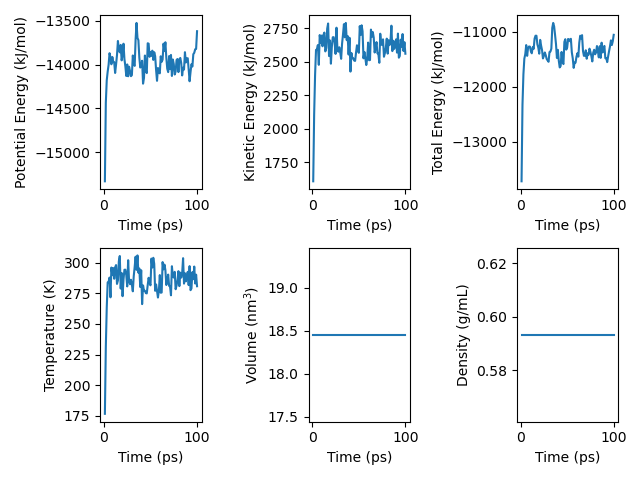

In [6]:
plotv('tip3p',289)

We can notice a few things. At the beginning of the simulation, the temperature is small, and so is the kinetic energy. As the system is heated, the temperature increases until we reach our target temperature of 298 K. Then, the energies and temperature fluctuate around a stable average value. Even though this is a constant temperature simulation, the temperature is not strictly constant but it is allowed to fluctuate. For NVT simulations, the volume is strictly constant, and it clear that it does not change overtime. Because both the volume and the number of particles (and mass) are constant, the density is also constant. However, the current density is very far from the expected density of water at 298 K and 1 bar ($\sim 1$ g/mL) because of the bubble in the box. By running NPT simulation, we can stabilize the density.

### Analysis of the NPT Simulation

Again, we will visualize the trajectory and then plot the same thermodynamic variables.

In [ ]:
view('tip3p', 289, 'p')

In the NPT simulation, the volume of the box is allowed to change. The bubble gradually decreases in size until it disappears completely. In turn, the volume of the box also decreases and then becomes stable.

The average density is 0.993183 at 289.29 K
The standard deviation of the density is 0.013768 at 289.29 K


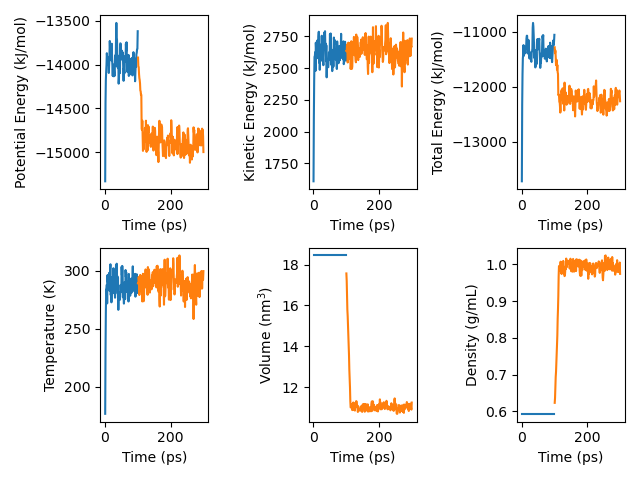

In [8]:
plotp('tip3p', 289)

We notice that the temperature is still stable at the target temperature of 298 K, and the kinetic energy also remains stable. The potential energy improves as the molecules come closer until it reaches a stable value. This in turn affects the total energy. The volume decreases rapidly as pressure is applied and it reaches a stable value. Because the volume decreases, the density increases until it reaches the expected value of $\sim 1$ g/mL.

These plots show why we need equilibration and production stages. At the beginning of the NVT and NPT simulations, the thermodynamic parameters can change substantially before the system reaches a stable state. The initial parts of the MD trajectory should be discarded until the system reaches equilibrium. For the purpose of the current analysis, we will only use the second half the NPT trajectory for the production stage. This will give us 100 data point for the analysis. It should be noted that realistic simulations usually require long simulation times in order to gather meaningful statistics.

From the MD trajectory of liquid simulations, we can extract some useful information, such as the density of the liquid. We can also calculate structural parameters, such as the oxygen-oxygen radial distribution function plotted below:

<function matplotlib.pyplot.show(close=None, block=None)>

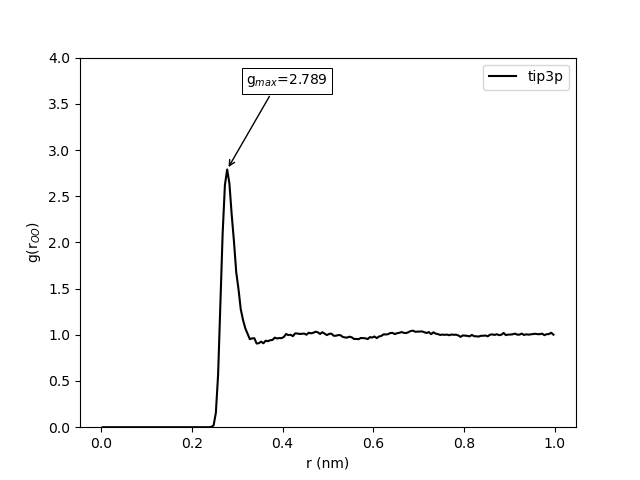

In [9]:
rf('tip3p', 289)

### Your Turn
**Repeat the above simulations and analyses using the SPC/E force field.**

### Comparison between the TIP3P and SPC/E Force Fields for the Radial Distribution Function
Below, we will plot the oxygen-oxygen radial distribution function determined from the TIP3P and the SPC/E simulations. We will compare them to experiment and determine which force field provides a better prediction for the structure of water.

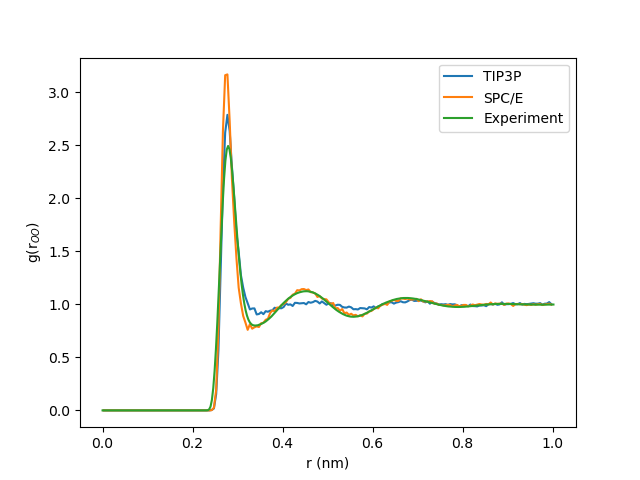

In [6]:
import mdtraj as md
import matplotlib.pyplot as plt
def comp(T):
    
    plt.figure()
    # Plot the RDF for the TIP3P and SPC/E simulations
    traj1 = md.load_dcd( 'tip3p' + '_' + str(T) + "_N"+"P"+"T.dcd", top="water.pdb")
    traj1 = traj1[traj1.n_frames//2:] # Exclude half the trajectory for equilibration
    pairs1 = traj1.top.select_pairs("name O", "name O") # select all pairs of atoms
    r, g = md.compute_rdf(traj1, pairs1, r_range=[0, 1]) # from 0 to 1 nm
    plt.plot(r, g, label = 'TIP3P')
    traj = md.load_dcd('spce' + '_' + str(T) + "_N"+"P"+"T.dcd", top="water.pdb")
    traj = traj[traj.n_frames//2:] # Exclude half the trajectory for equilibration
    pairs = traj.top.select_pairs("name O", "name O") # select all pairs of atoms
    r1, g1 = md.compute_rdf(traj, pairs, r_range=[0, 1]) # from 0 to 1 nm
    plt.plot(r1, g1, label = 'SPC/E')
    r, g = np.loadtxt("experimental_rdf.txt", usecols=(0, 1), unpack=True)
    plt.plot(r/10.0, g, label="Experiment")
    plt.xlabel("r (nm)")
    plt.ylabel("g(r$_{OO}$)")
    plt.legend()
    return plt.show()
comp(289)

**Is the TIP3P or the SPC/E force field better at reproducing the experimental trend for the radial distribution function?**

Answer: SPC/E is better 

## Part II: The Density and Radial Distribution Function at Various Temperatures
In Part I, we learned the basic procedure for running MD simulations. Now we want to use MD simulations to predict the effect of temperature on the density and radial distribution function of water.

Using the same python scripts as above, perform the MD simulations at 5, 20, 35, 50, 65, 80, and 95 $^\circ$C. Calculate the average and standard deviation of the density and plot the density against the temperature. Search in the web to find the experimentally determined temperature dependence. Comment on the agreement between your predictions and the experimentally determined trend.

Additionally, calculate and plot the radial distribution function at each temperature. Comment on the effect of the temperature on the structure of water.

In [29]:
# Perform the simulations
temps=[5,20,35,50,65,80]
for i in range(len(temps)):
    prot('spce', temps[i]+273)

<function matplotlib.pyplot.show(close=None, block=None)>

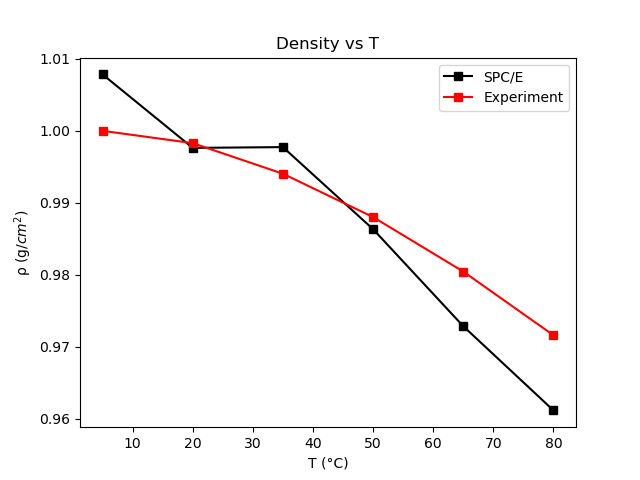

In [7]:
# Plot the density vs temperature
temps=[5,20,35,50,65,80]
ds=[]
exds=[1000,998.29,994.04,988.02,980.45,971.60]
exDensity=[x/1000 for x in exds]
for i in range(len(temps)):
    a = den('spce', temps[i]+273)
    ds.append(a)
figure = plt.figure()
plt.title('Density vs T')
plt.plot(temps, ds,'k',marker='s', label='SPC/E')
plt.plot(temps, exDensity,'r',marker='s',label='Experiment')
plt.xlabel("T (°C)")
plt.ylabel("ρ (g/$cm^2$)")
plt.legend()
plt.show

**Comment on the effect of the temperature on the density.**


Answer: The density is inversely proportional to the temperature

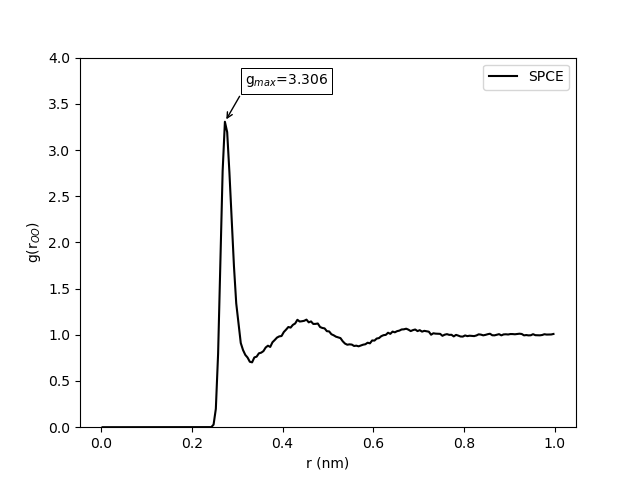

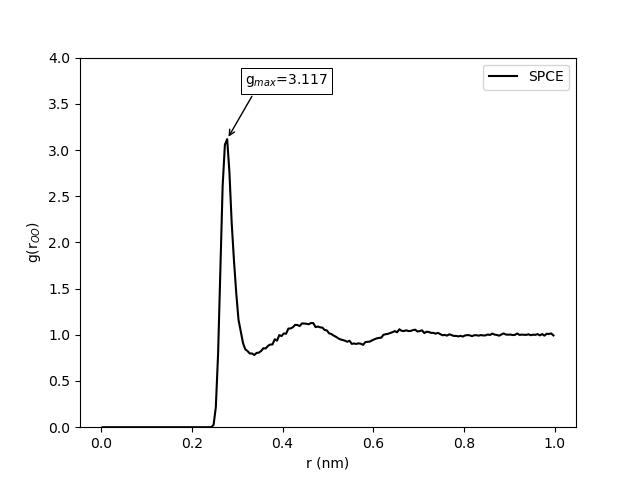

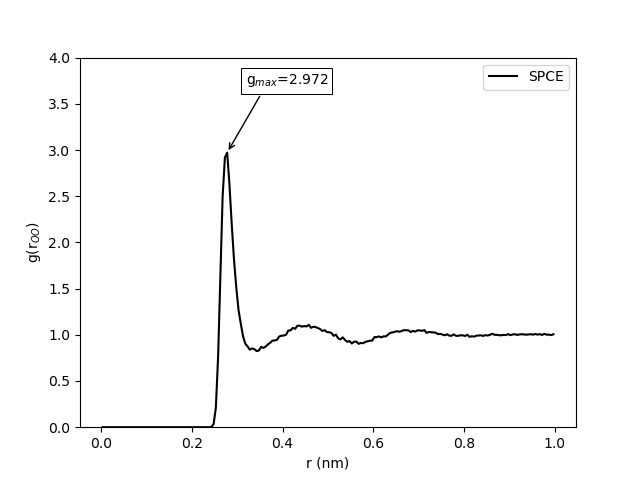

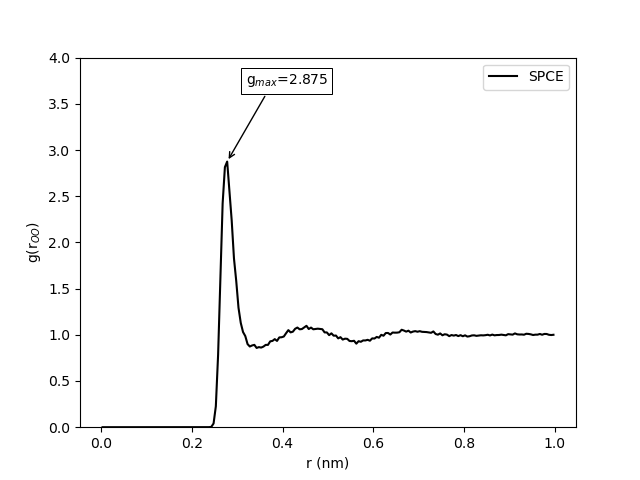

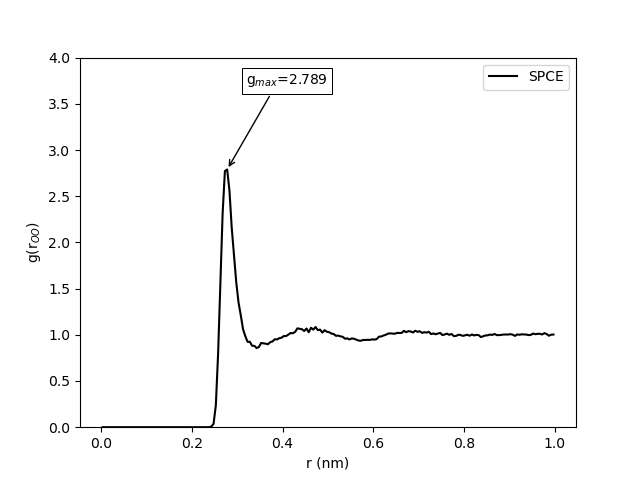

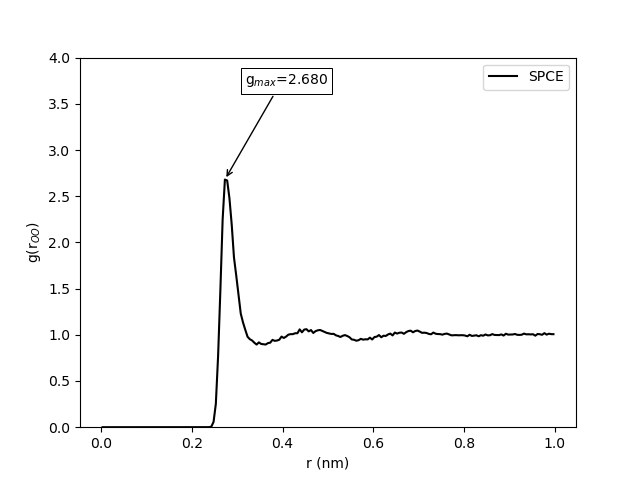

In [8]:
# Plot the radial distribution function for the different temperatures

for i in range(len(temps)):
    rf("SPCE",temps[i]+273)




**Comment on the effect of the temperature on the radial distribution function.**

Answer: The peaks shrinks as we increase the temperature

## Conclusion
Summarize what you learned in this lab in a few points:
- Point 1: SPC/E is better than TIP3P for simulating liquid water
- Point 2: The density decreases as temperature increases
- Point 3: We can study macroscopic properties of liquids using MD calculations 
- Point 4: These simulations take time unless you have a good GPU (like mine)